In [1]:
from random import sample 
from scipy.integrate import quad
from random import choices
import seaborn as sns
from scipy import constants as const
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import warnings
from numpy.linalg import multi_dot, norm
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings('ignore')

## Infinite Potential Well

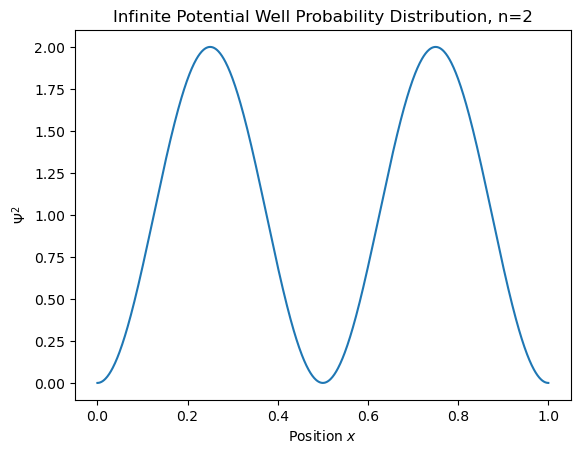

In [2]:
a = 1 # Size of the Well
n= 2  # Principal quantum number (1st excited state)

x = np.linspace(0,a,1000) #Position values
y_inf = (np.sqrt(2/a)*np.sin((n*np.pi*x)/a)) # Psi Values

plt.plot(x,y_inf**2) #Plotting position values against Psi^2
plt.title("Infinite Potential Well Probability Distribution, n=2")
plt.xlabel('Position $x$')
plt.ylabel('$\Psi^2$')
plt.show()

In [3]:
# # To confirm function is normalized
# x2 = lambda x: (np.sqrt(2/a)*np.sin((n*np.pi*x)/a))**2
# quad(x2, 0, 1)[0]

Text(0.5, 1.0, 'Randomly Sampled Infinite Potential Well, n=2')

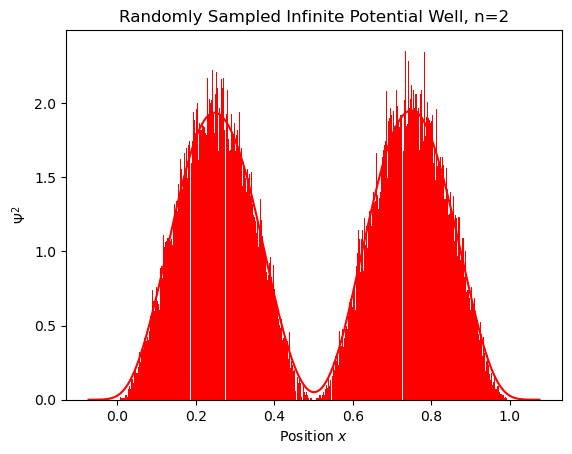

In [4]:
# Drawing a random sample from the probability distribution
p = choices(x, y_inf**2, k=10**5)    #This draws random samples from the position values according to their weight in the probability distribution
ax = sns.distplot(p,
                  bins=1000,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set_xlabel('Position $x$')
ax.set_ylabel('$\Psi^2$')
ax.set_title('Randomly Sampled Infinite Potential Well, n=2')

### The position $x$ is our data. The ideal situation entails looking at the measured probability distribution from a quantum mechanical measurement of the potential being studied. We would then have a probability density value $y$ attributed to each $x$. The question at hand is then, given this position $x$ data, what model/trial function, and parameters (slope,bias,etc.) of those models, give us as a prediction $y_{pred}$ as close as possible to the true ideal probability distribution $y$.

### To fir polynomials to out data, we need to transform it. For example, if we choose to try representing the value y (prob. distrib. in our case), using a polynomial that is of the 5th dimension in x, it would look like this:
# $y = ax^5 +bx^4 +cx^3 + dx^2 + gx + r$
### It is very important to note that it only looks this simple because our data is 1-Dimensional in this example. When we have higher dimensionality, we end up with cross terms, making the polynomial more complicated.

In [5]:
#Splitting Data to Train and Test 
Total_X = x
Total_Y = y_inf**2

Total_X = Total_X.reshape(len(Total_X),1)
Total_Y = Total_Y.reshape(len(Total_Y),1)

X_Train,X_Test,Y_Train,Y_Test = train_test_split(Total_X,Total_Y,test_size=0.3, train_size=0.7)

In [6]:
#Reshaping the data vector from (T,) to (T,1)
X_Train = X_Train.reshape(len(X_Train),1)
Y_Train = Y_Train.reshape(len(Y_Train),1)

X_Test = X_Test.reshape(len(X_Test),1)
Y_Test = Y_Test.reshape(len(Y_Test),1)

### The following is how we retrieve the optimal parameters of this model, in our case, these are the coefficients to each of the terms in our polynomial.

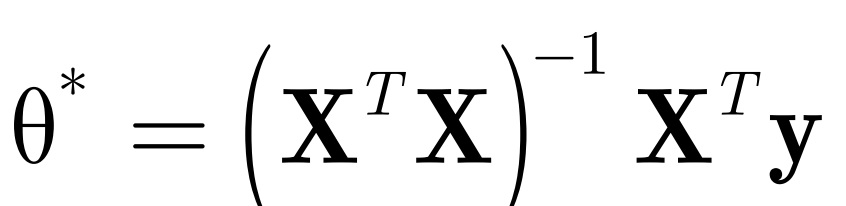

In [7]:
def Train(Dimension,Degree,X_Train,X_Test,Y_Train,Y_Test):  #Function to assess training and testing loss for each polynomial degree chosen
    R_Training = []
    R_Testing = []

    for i in range(Dimension-1,Degree):
     #Retrieving Polynomials of Degree i
        poly = PolynomialFeatures(degree=i)  #Preparing the polynomial transformation
        Training_X, Testing_X = poly.fit_transform(X_Train), poly.fit_transform(X_Test)  #Applying the transofrmation to our data
        #Matrix Multiplication To Reach Optimal Parameters
        XX = np.matmul(np.transpose(Training_X),Training_X)
        XX_Inv = np.linalg.inv(XX)
        Thetas = multi_dot([XX_Inv,np.transpose(Training_X),Y_Train])

        #Calculating Training & Testing Resk
        R_Training.append(np.sum(np.square([Y_Train- np.matmul(Training_X,Thetas)]))/(2*len(Training_X)))
        R_Testing.append(np.sum(np.square([Y_Test - np.matmul(Testing_X,Thetas)]))/(2*len(Testing_X)))
        if R_Testing[-1] == min(R_Testing):
            Optimal_Theta = Thetas
            Optimal_Testing_X = Testing_X
    return Optimal_Theta,Optimal_Testing_X,R_Training,R_Testing

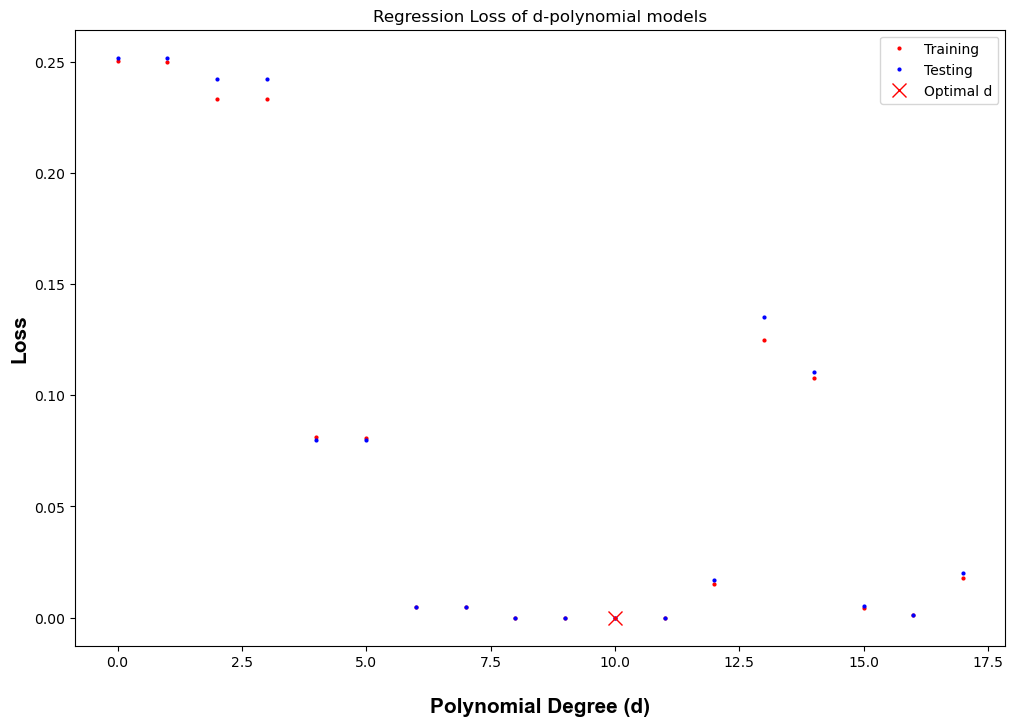

In [8]:
Degree = 18      #Number of Degrees up to wich we want to try our fit
Dimension = 1    #Dimension of data for infinite well

Optimal_Theta,Optimal_Testing_X,R_Training,R_Testing = Train(Dimension,Degree,X_Train,X_Test,Y_Train,Y_Test)
index_min_R_Testing = R_Testing.index(min(R_Testing))

#Plotting The Risk Against the Polynomial Degree Used, and marking the lowest value of testing risk.
plt.figure(figsize=(12,8), dpi=100)
plt.xlabel('\nPolynomial Degree (d)', fontdict = {'fontname': 'Arial', 'fontsize': 15, 'fontweight': 'bold'})
plt.ylabel('Loss', fontdict = {'fontname': 'Arial', 'fontsize': 15,'fontweight': 'bold'})
x_axis = [i for i in range(Dimension-1,Degree)]
plt.plot(x_axis,R_Training,'.',markersize=4,color='red',label='Training')
plt.plot(x_axis,R_Testing,'.',markersize=4,color='blue',label='Testing')
plt.plot(x_axis[index_min_R_Testing],min(R_Testing),'x',color='red', markersize=10, label='Optimal d')
plt.title('Regression Loss of d-polynomial models')
plt.legend()

### We now have the optimal degree for the polynomial fit, as well as the optimal parameters. We will randomly sample a set of x values in our interval and see if our prediction is a good fit.

In [9]:
poly = PolynomialFeatures(degree=index_min_R_Testing)
x_sample = poly.fit_transform(np.array(p).reshape(len(p),1))   # p is the randomly drawn sample

#Our prediction for a random sample of x
newy = np.matmul(x_sample,Optimal_Theta)

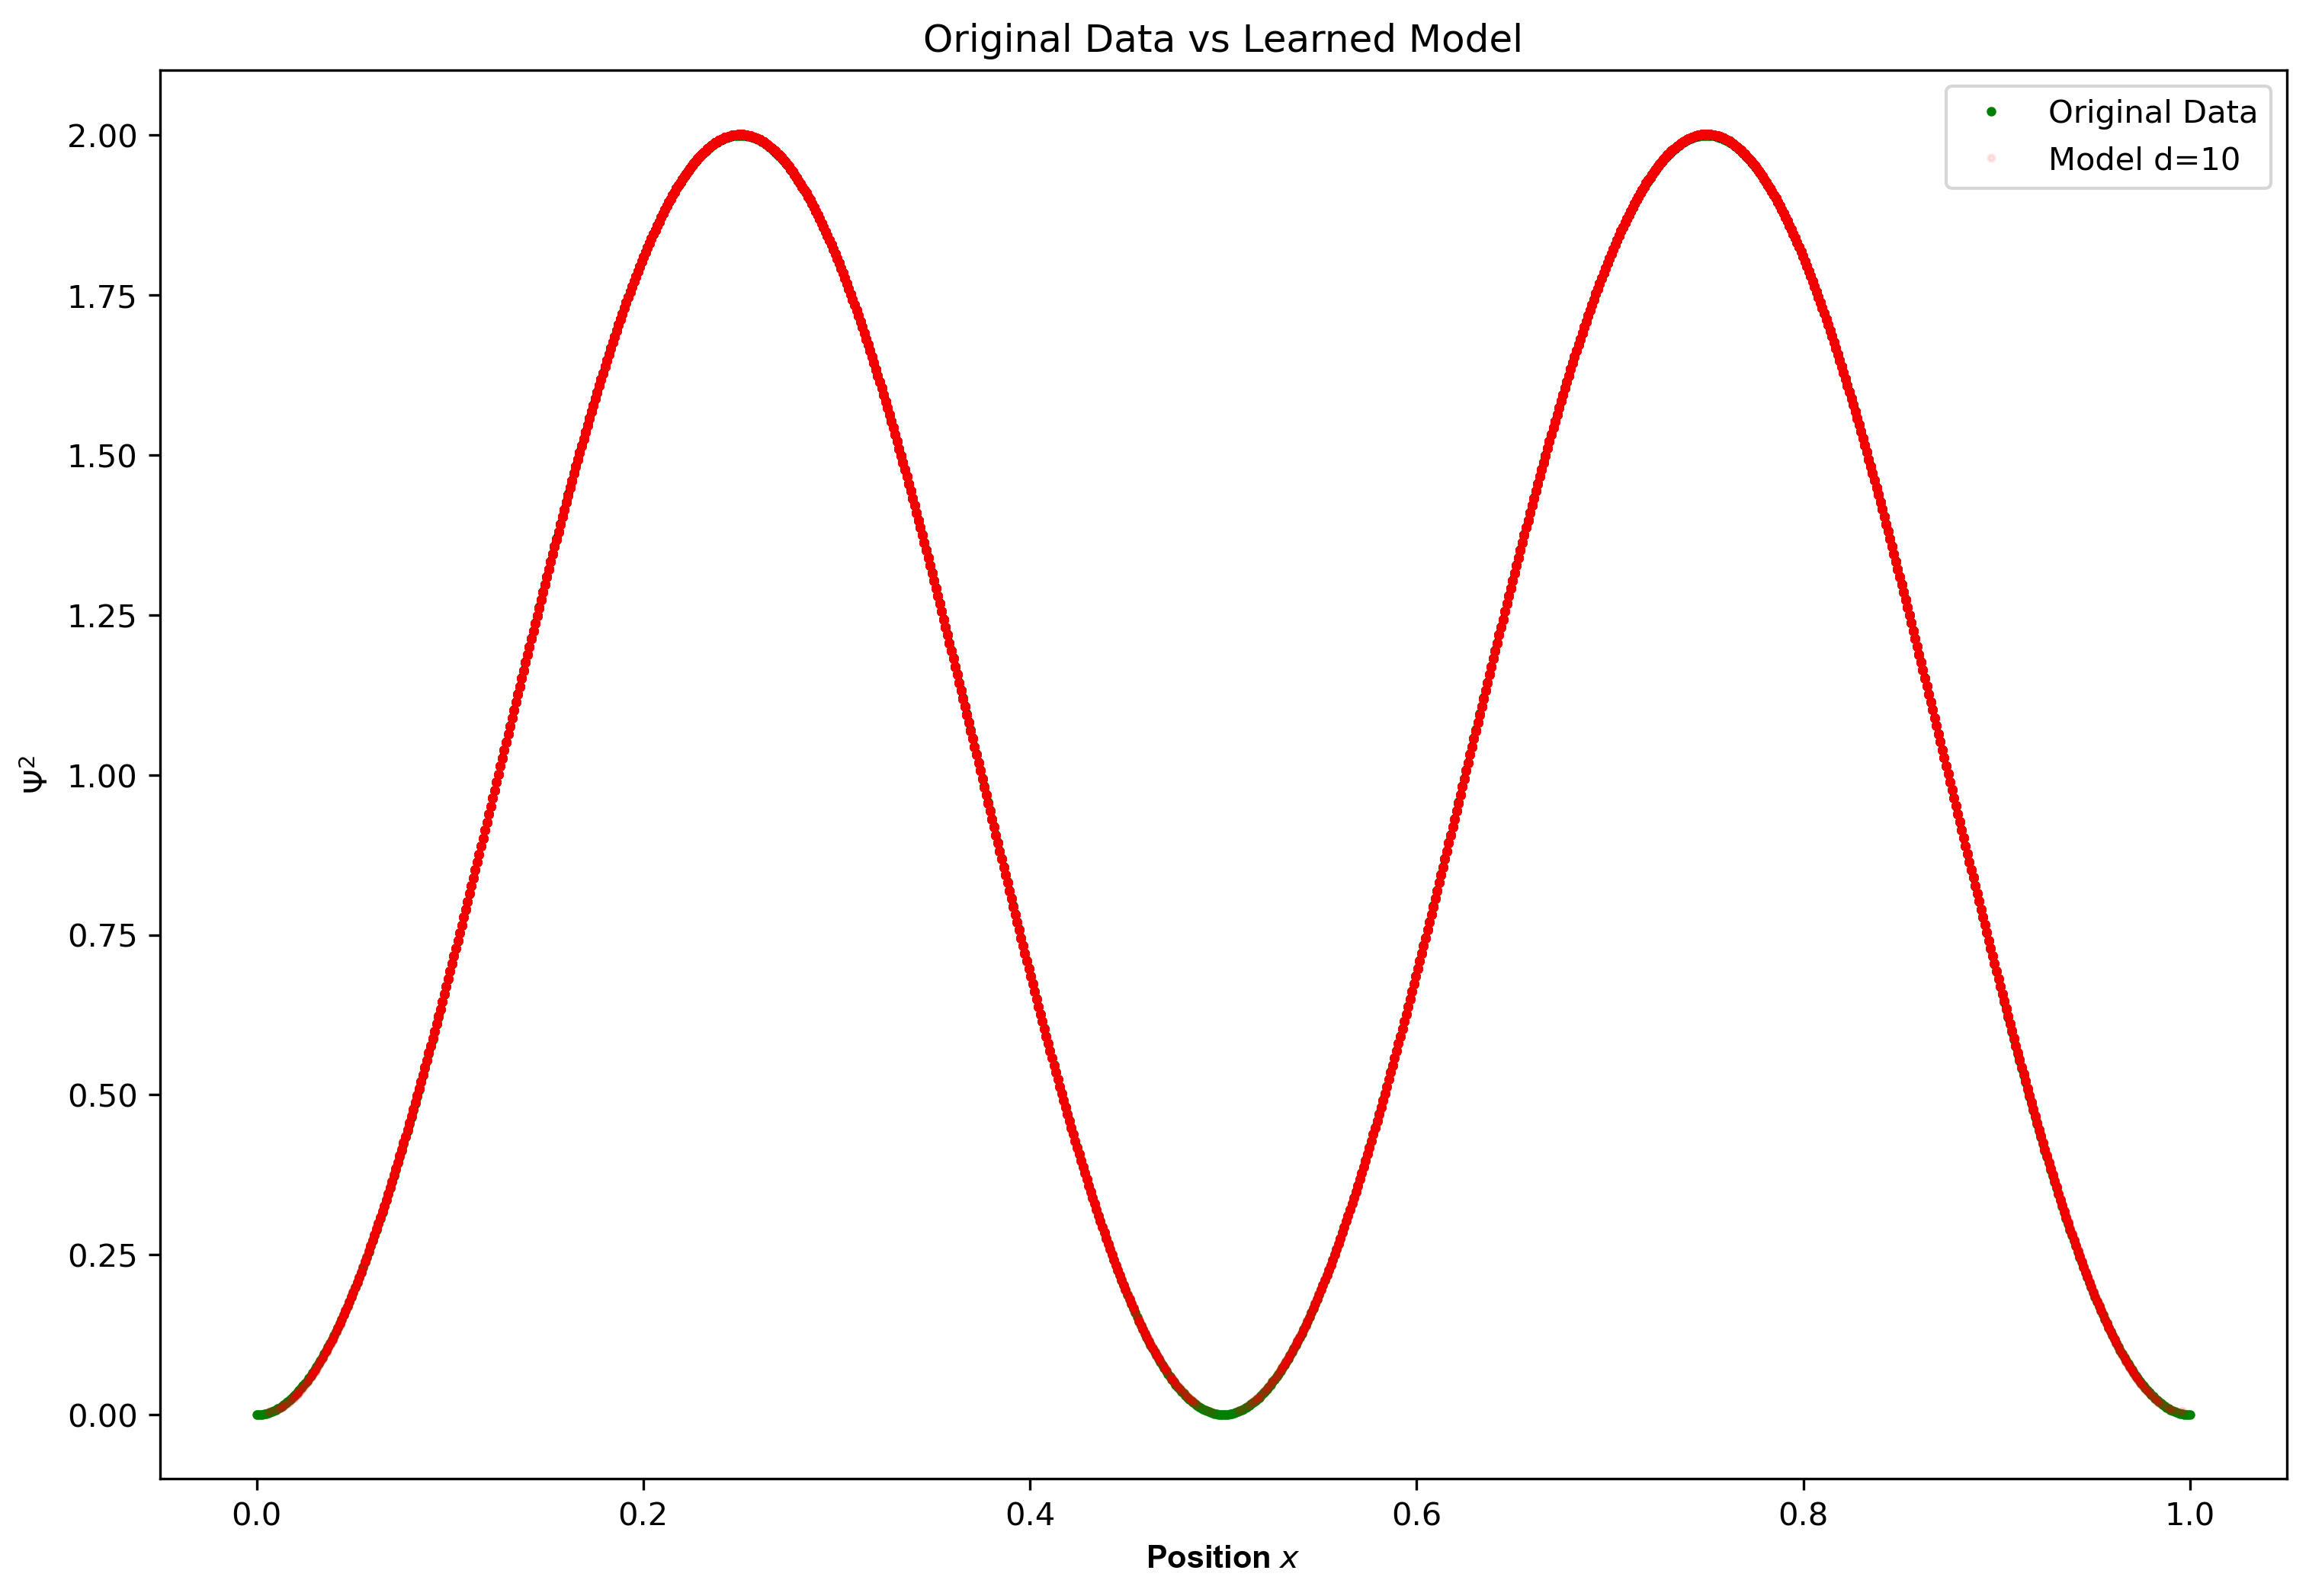

In [10]:
plt.figure(figsize=(12,8), dpi=300)
plt.xlabel('Position $x$', fontdict = {'fontname': 'Arial', 'fontsize': 10, 'fontweight': 'bold'})
plt.ylabel('$\Psi^2$', fontdict = {'fontname': 'Arial', 'fontsize': 10,'fontweight': 'bold'})

plt.plot(Total_X,Total_Y,'.', markersize=4,color='green',label='Original Data')
plt.plot(p,newy,'.', markersize=4, color='red',label=f'Model d={index_min_R_Testing}',alpha=0.09)
plt.title('Original Data vs Learned Model')
plt.legend()


## Harmonic Oscillator

### The following is the probability distribution for the 2nd excited (n=2) 1-D Harmonic Oscillator.
# $\psi_{n=2}^2 = ||{\left(\frac{mw}{h\pi}\right)^{1/4} \cdot \left(\frac{1}{2}\right)^{1/2}\cdot exp(\frac{-mwx^2}{2h})}||^2$

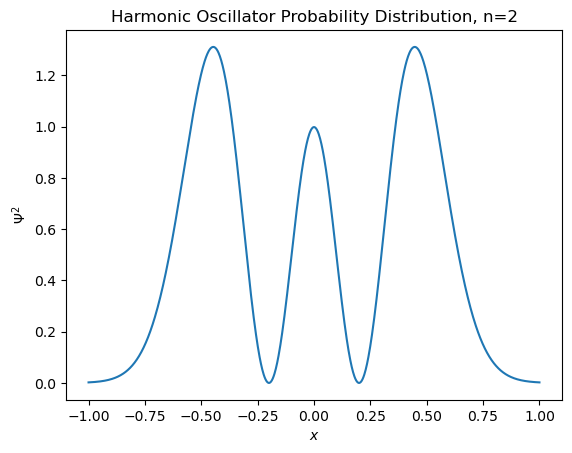

In [11]:
m = const.m_e
w = 0.00145
h = const.hbar 
a = 1

x_harm = np.linspace(-a,a,1000)
# y_harm = ((m*w)/(h*np.pi))**(1/4) * np.exp( -m*w*(x**2) / (2*h)) # n =0
y_harm = ((m*w)/(h*np.pi))**(1/4) * np.sqrt(1/2)* (2*m*w*(x_harm**2)/(h) - 1) * np.exp( -m*w*(x_harm**2) / (2*h)) # n =2

plt.plot(x_harm,y_harm**2)
plt.title("Harmonic Oscillator Probability Distribution, n=2")
plt.xlabel('$x$')
plt.ylabel('$\Psi^2$')
plt.show()

In [12]:
#Can be used to check normalization
# x3 = lambda x: (((m*w)/(h*np.pi))**(1/4) * np.sqrt(1/2)* (2*m*w*(x**2)/(h) - 1) * np.exp( -m*w*(x**2) / (2*h)))**2
# quad(x3, -a, a)[0]

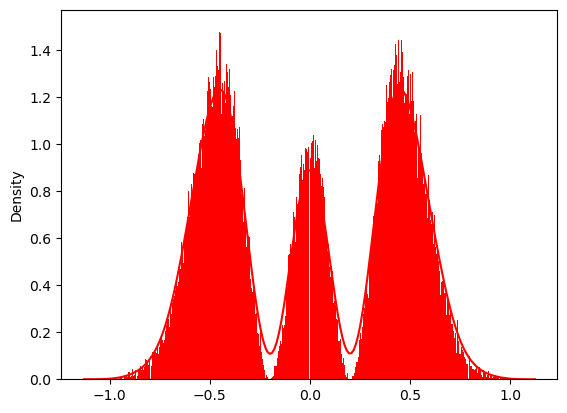

In [13]:
p_harm = choices(x_harm, y_harm**2, k=10**5)
ax = sns.distplot(p_harm,
                  bins=1000,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1})

In [14]:
Total_X = x_harm
Total_Y = y_harm**2

X_Train,X_Test,Y_Train,Y_Test = train_test_split(Total_X,Total_Y,test_size=0.3, train_size=0.7)

X_Train = X_Train.reshape(len(X_Train),1)
Y_Train = Y_Train.reshape(len(Y_Train),1)

X_Test = X_Test.reshape(len(X_Test),1)
Y_Test = Y_Test.reshape(len(Y_Test),1)

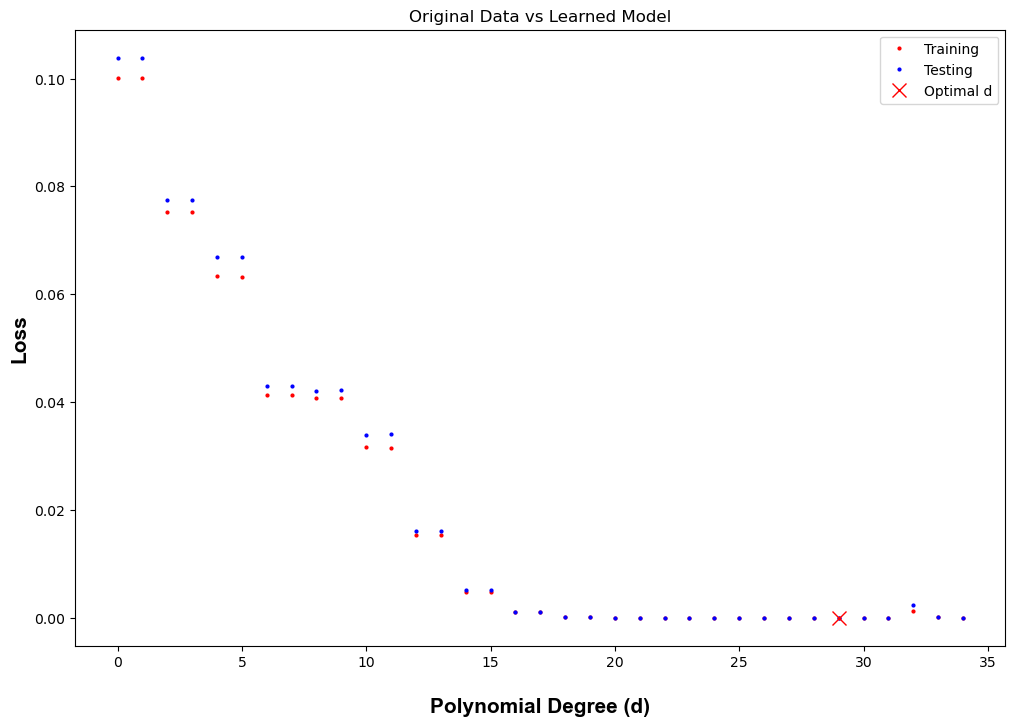

In [15]:
Degree =35
Dimension =1

Optimal_Theta,Optimal_Testing_X,R_Training,R_Testing = Train(Dimension,Degree,X_Train,X_Test,Y_Train,Y_Test)
#Plotting The Risk Against the Polynomial Degree Used, and marking the lowest value of testing risk.
index_min_R_Testing = R_Testing.index(min(R_Testing))
plt.figure(figsize=(12,8), dpi=100)
plt.xlabel('\nPolynomial Degree (d)', fontdict = {'fontname': 'Arial', 'fontsize': 15, 'fontweight': 'bold'})
plt.ylabel('Loss', fontdict = {'fontname': 'Arial', 'fontsize': 15,'fontweight': 'bold'})
x_axis = [i for i in range(Degree)]
plt.plot(x_axis,R_Training,'.',markersize=4,color='red',label='Training')
plt.plot(x_axis,R_Testing,'.',markersize=4,color='blue',label='Testing')
plt.plot(x_axis[index_min_R_Testing],min(R_Testing),'x',color='red', markersize=10,label='Optimal d')
plt.title('Original Data vs Learned Model')

plt.legend()

In [16]:
poly = PolynomialFeatures(degree=index_min_R_Testing)
x_sample = poly.fit_transform(np.array(p_harm).reshape(len(p_harm),1))   # p is the randomly drawn sample

#Our prediction for a random sample of x
newy = np.matmul(x_sample,Optimal_Theta)

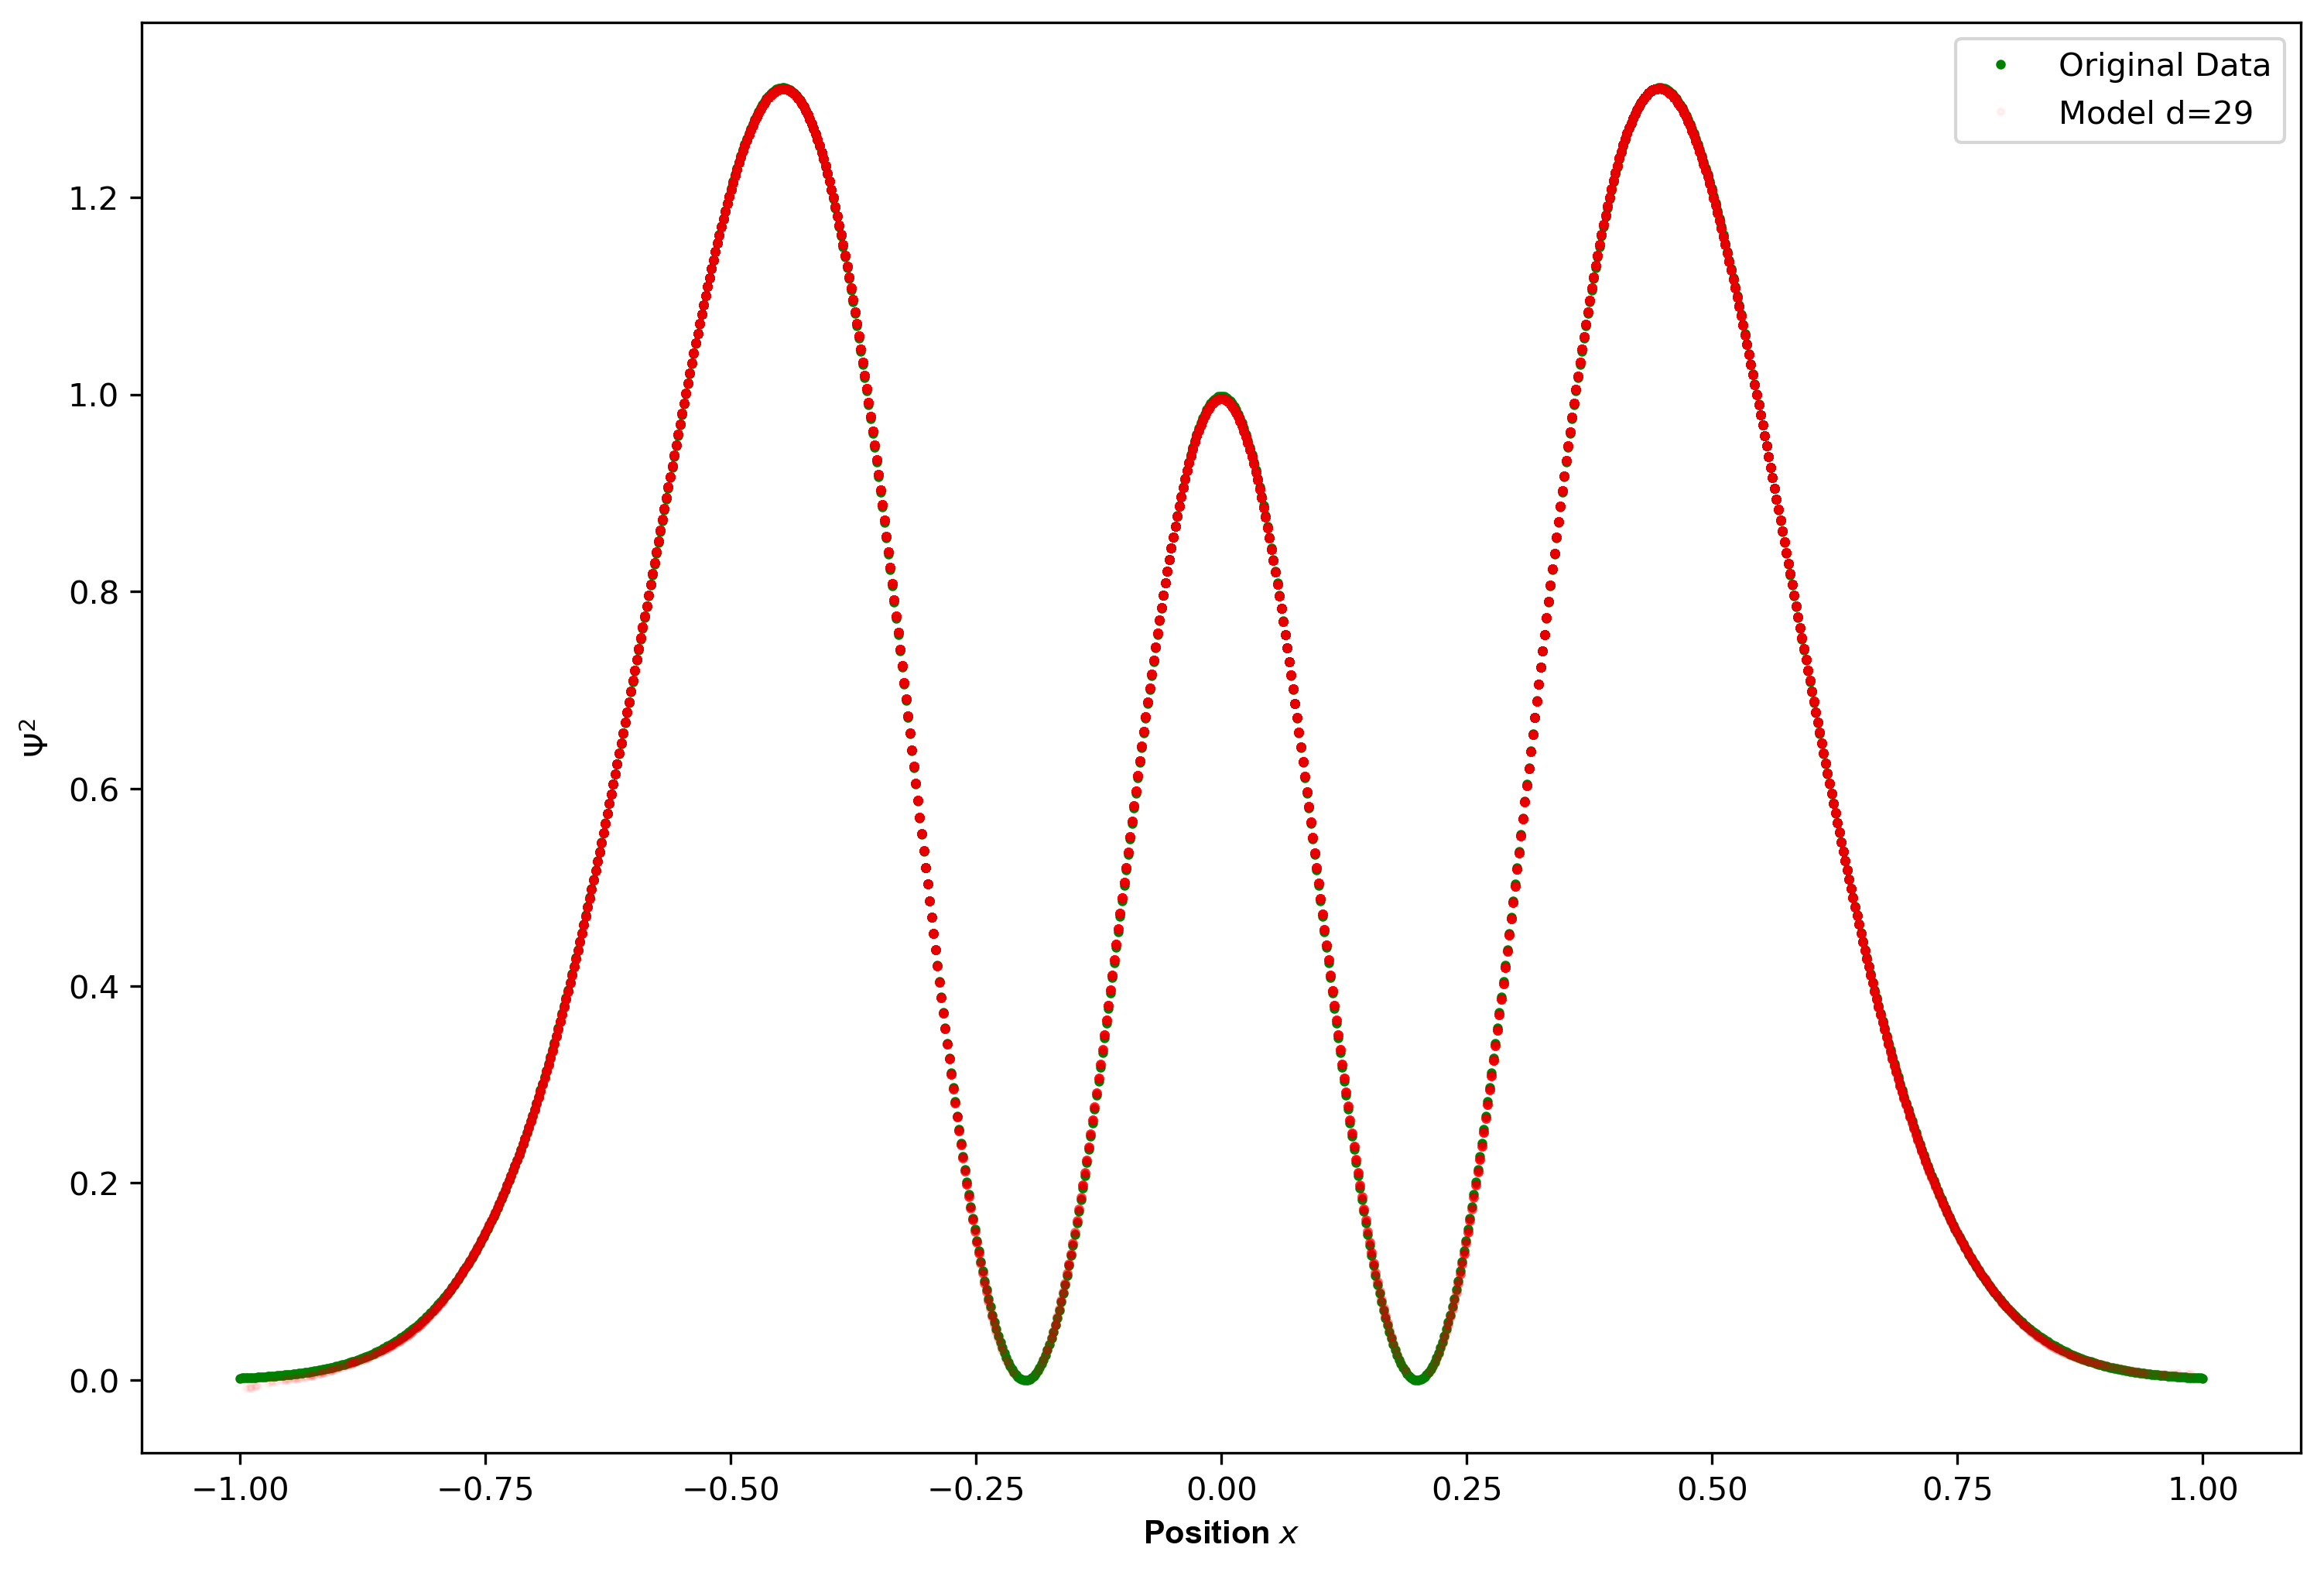

In [17]:
plt.figure(figsize=(12,8), dpi=300)
plt.xlabel('Position $x$', fontdict = {'fontname': 'Arial', 'fontsize': 10, 'fontweight': 'bold'})
plt.ylabel('$\Psi^2$', fontdict = {'fontname': 'Arial', 'fontsize': 10,'fontweight': 'bold'})

plt.plot(Total_X,Total_Y,'.', markersize=4,color='green',label='Original Data')
plt.plot(p_harm,newy,'.', markersize=4, color='red',label=f'Model d={index_min_R_Testing}',alpha=0.04)

plt.legend()


### The following is what the probability distribution looks like in the polynomial representation. This expression goes up to the degree of our optimal hyperparameter, and the coefficients are the optimal parameters we learned.

In [18]:
t = [str(round(Optimal_Theta[i][0],3)) + f' x^{i}' + '+' for i in range(len(Optimal_Theta))]
print("Psi^2 = \n")
for i in t:
    print(i)

Psi^2 = 

0.996 x^0+
-0.016 x^1+
-61.61 x^2+
1.713 x^3+
1283.314 x^4+
-55.798 x^5+
-11080.643 x^6+
828.367 x^7+
55010.511 x^8+
-6830.607 x^9+
-178352.104 x^10+
34575.973 x^11+
397504.927 x^12+
-113075.375 x^13+
-618877.602 x^14+
242899.367 x^15+
671936.352 x^16+
-334585.219 x^17+
-508488.344 x^18+
261730.18 x^19+
284309.516 x^20+
-45070.335 x^21+
-147224.258 x^22+
-124150.275 x^23+
82608.996 x^24+
130201.866 x^25+
-35517.924 x^26+
-55845.716 x^27+
6947.873 x^28+
9375.881 x^29+


### Why is this useful? For starters, you can now find a very good estimate of probability distribution $\Psi^2(x)$ values for intermediate $x$ values that were not in your training dataset. You now also have a different way of representing your wavefunction; polynomial in this exercise, as opposed to sinusoidal in the infinite well, or the exponential in the harmonic oscillator.

## 2-D Infinite Well

Text(0.5, 0, '$\\Psi^2$')

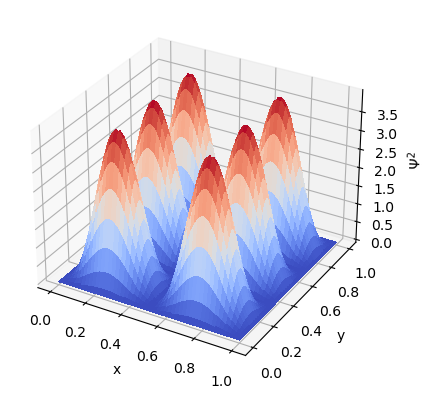

In [19]:
x = np.linspace(0,a,300) #Position values
y = np.linspace(0,a,300) #Position values

nx=2
ny=3

x_2D,y_2D = np.meshgrid(x,y)
z_mesh = (np.sqrt(2/a)*np.sin((nx*np.pi*x_2D)/a)) * (np.sqrt(2/a)*np.sin((ny*np.pi*y_2D)/a))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x_2D, y_2D, z_mesh**2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\Psi^2$')


# fig.colorbar(surf, shrink=0.5, aspect=5)

In [20]:
z = []
Two_D = []
for i in x:
    for j in y:
        Two_D.append([i,j])     #Creating 2-dimensional array [[a,b],[c,d],...]
        z.append(((np.sqrt(2/a)*np.sin((nx*np.pi*i)/a)) * (np.sqrt(2/a)*np.sin((ny*np.pi*j)/a)))**2)  #Creating the labels Psi^2

Two_D = np.array(Two_D)
z=np.array(z)

In [21]:
Total_X = Two_D
Total_Y = z

Total_Y = Total_Y.reshape(len(Total_Y),1) #reshaping from (x,) to (x,1), Explicity written for clarity

X_Train,X_Test,Y_Train,Y_Test = train_test_split(Total_X,Total_Y,test_size=0.3, train_size=0.7)

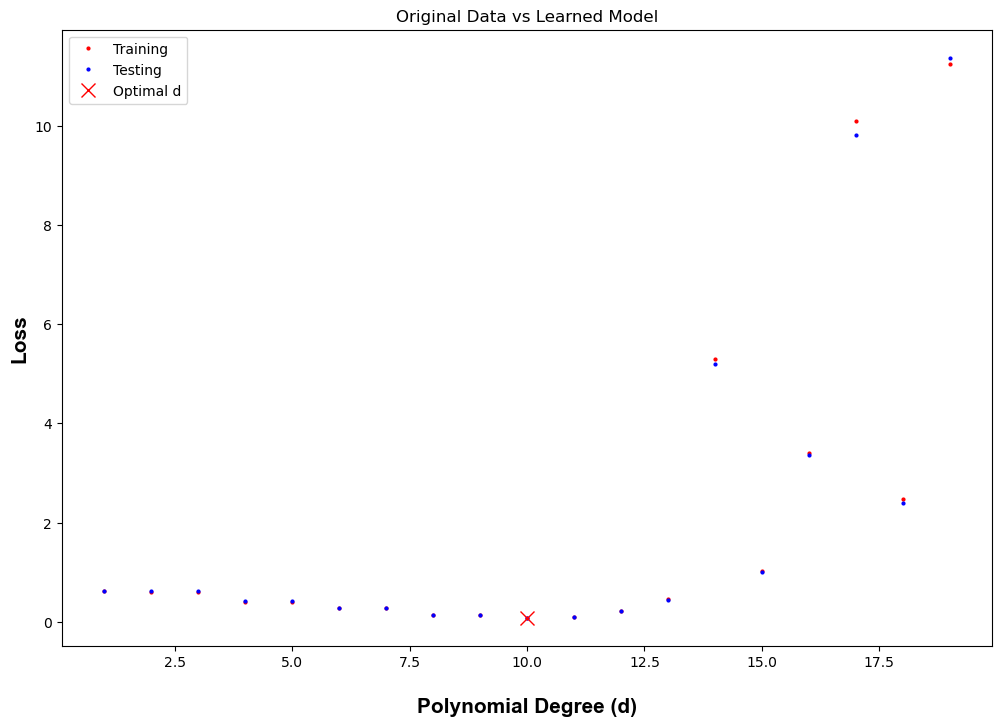

In [22]:
Degree = 20
Dimension=2
 
Optimal_Theta,Optimal_Testing_X,R_Training,R_Testing = Train(Dimension,Degree,X_Train,X_Test,Y_Train,Y_Test)

# Plotting The Risk Against the Polynomial Degree Used, and marking the lowest value of testing risk.
index_min_R_Testing = R_Testing.index(min(R_Testing))
plt.figure(figsize=(12,8), dpi=100)
plt.xlabel('\nPolynomial Degree (d)', fontdict = {'fontname': 'Arial', 'fontsize': 15, 'fontweight': 'bold'})
plt.ylabel('Loss', fontdict = {'fontname': 'Arial', 'fontsize': 15,'fontweight': 'bold'})
plt.title('Original Data vs Learned Model')

x_axis = [i for i in range(Dimension-1,Degree)]

plt.plot(x_axis,R_Training,'.',markersize=4,color='red',label='Training')
plt.plot(x_axis,R_Testing,'.',markersize=4,color='blue',label='Testing')
plt.plot(x_axis[index_min_R_Testing],min(R_Testing),'x',color='red', markersize=10,label='Optimal d')
plt.legend()

In [23]:
poly = PolynomialFeatures(degree=x_axis[index_min_R_Testing])
Optimal_X = poly.fit_transform(Total_X)
finaly = np.transpose(np.matmul(Optimal_X,Optimal_Theta).reshape(x.shape[0],x.shape[0]))

Text(0.5, 0, '$\\Psi^2$')

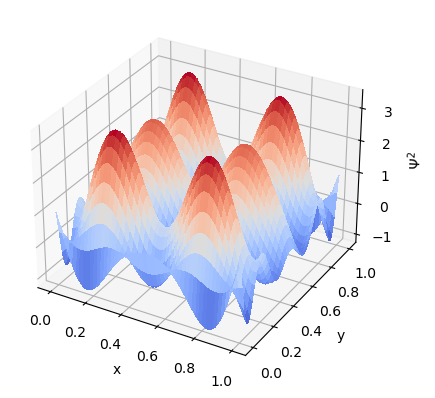

In [24]:
nx=2
ny=3

# X,Y = np.meshgrid(x,y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x_2D, y_2D, finaly, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\Psi^2$')


### Not too bad of an estimate. There seems to be good resemblance, but not near good enough for practical purposes. Perhaps, change of modelling function is due. Let us try the radial basis function (rbf)

# Two-D Infinite Well using Radial Basis Functions (RBF)

Text(0.5, 0, '$\\Psi^2$')

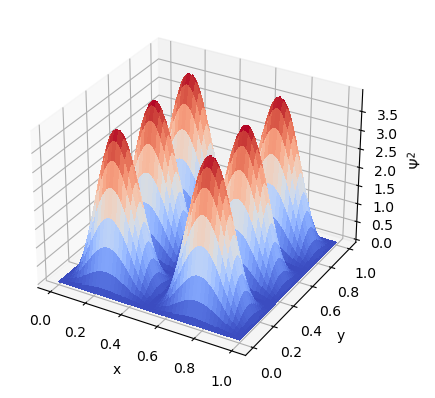

In [25]:
a=1
x = np.linspace(0,a,100) #Position values
y = np.linspace(0,a,100) #Position values
nx=2
ny=3
x_mesh,y_mesh = np.meshgrid(x,y)
z_mesh = (np.sqrt(2/a)*np.sin((nx*np.pi*x_mesh)/a)) * (np.sqrt(2/a)*np.sin((ny*np.pi*y_mesh)/a))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x_mesh, y_mesh, z_mesh**2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\Psi^2$')


# fig.colorbar(surf, shrink=0.5, aspect=5)

In [26]:
z = []
Two_D = []
for i in x:
    for j in y:
        Two_D.append([i,j])     #Creating 2-dimensional array [[a,b],[c,d],...]
        z.append(((np.sqrt(2/a)*np.sin((nx*np.pi*i)/a)) * (np.sqrt(2/a)*np.sin((ny*np.pi*j)/a)))**2)  #Creating the labels Psi^2

Two_D = np.array(Two_D)
z=np.array(z).reshape(len(z),1)

### The following cell is a method for computing the needed Kernel matrix of the data. It is however very inefficient and took a very long time to run, so I ended up using a more optimized method, rbf_kernel from the scikit library.

In [27]:
# #Contruction of NxN Kernel Data Matrix
# X = [[None]*len(Two_D) for i in range(len(Two_D))]  #Creating empty NxN matrix to populate

# for i in range(len(Two_D)):      #Filling all diagonal values with 1
#     X[i][i] = 1
    
# row_begin=1
# x_row = 0
# y_row = 0

# for i in Two_D: #Iterating through each 2-D Data vector
#     y_row=row_begin
#     if x_row < len(Two_D[row_begin:]):
#         for j in Two_D[row_begin:]: # Iterating through each 2-D Data vector after the vector from the first for loop
#             if y_row<len(Two_D[row_begin:]):
#                 X[x_row][y_row]=(norm(i-j)**2) #Computing square of the norm of the Euclidian vector distance
#                 y_row = y_row+1
#     row_begin=row_begin+1
#     x_row=x_row+1
    
# for i in range(len(Two_D)+1):     #Since the Kernel matrix is a square matrix, we populate entries j,i with those in i,j
#     for j in range(len(Two_D)+1):
#         X[j][i] = X[i][j]

In [28]:
R_Training = []
R_Testing = []
Sigmas = [0.0001,0.001, 0.005,0.01]

for sigma in Sigmas:
    print("Working on sigma: ",sigma)
    gamma = 1/(2*(sigma**2))
    K_Train = rbf_kernel(Two_D, gamma = gamma)
#     K_Test = rbf_kernel(X_Test, gamma = gamma)
    Inv = np.linalg.inv(K_Train)
    Theta = np.matmul(Inv,z)
    
    R_Training.append(np.sum(np.square([z- np.matmul(K_Train,Theta)]))/(2*len(K_Train)))
#     R_Testing.append(np.sum(np.square([Y_Test - np.matmul(K_Test,Theta)]))/(2*len(K_Test)))
    print("Your loss for sigma = ",sigma," is: ", R_Training[-1])
    if R_Training[-1] == min(R_Training):
            Optimal_Theta = Theta
            K_Optimal = K_Train

Working on sigma:  0.0001
Your loss for sigma =  0.0001  is:  0.0
Working on sigma:  0.001
Your loss for sigma =  0.001  is:  4.1327285674956343e-82
Working on sigma:  0.005
Your loss for sigma =  0.005  is:  1.801958057269021e-31
Working on sigma:  0.01
Your loss for sigma =  0.01  is:  4.646693800284616e-28


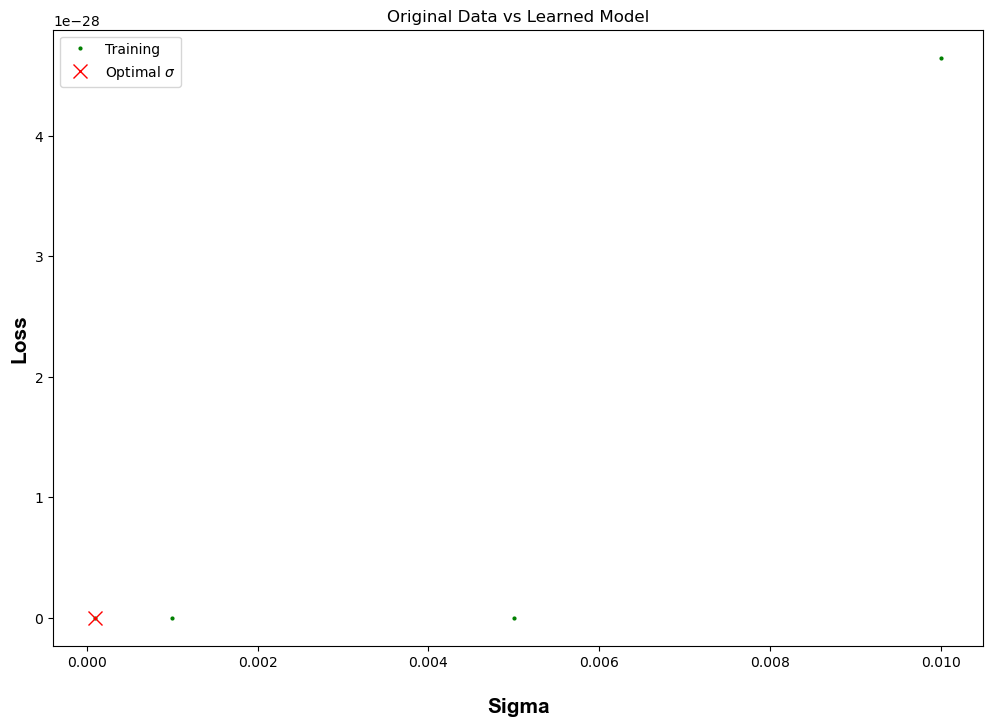

In [29]:
index_min_R_Training = R_Training.index(min(R_Training))
plt.figure(figsize=(12,8), dpi=100)
plt.xlabel('\nSigma', fontdict = {'fontname': 'Arial', 'fontsize': 15, 'fontweight': 'bold'})
plt.ylabel('Loss', fontdict = {'fontname': 'Arial', 'fontsize': 15,'fontweight': 'bold'})
plt.title('Original Data vs Learned Model')

x_axis = Sigmas

plt.plot(x_axis,R_Training,'.',markersize=4,color='green',label='Training')
plt.plot(x_axis[index_min_R_Training],min(R_Training),'x',color='red', markersize=10,label='Optimal $\sigma$')
plt.legend()

In [30]:
predictions = np.transpose(np.matmul(K_Optimal,Optimal_Theta).reshape(len(x),len(x)))

Text(0.5, 0, '$\\Psi^2$')

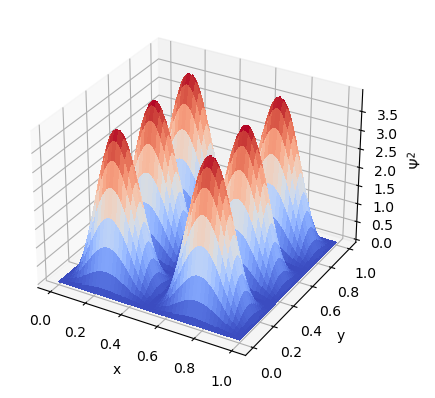

In [31]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(x_mesh, y_mesh, predictions, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\Psi^2$')

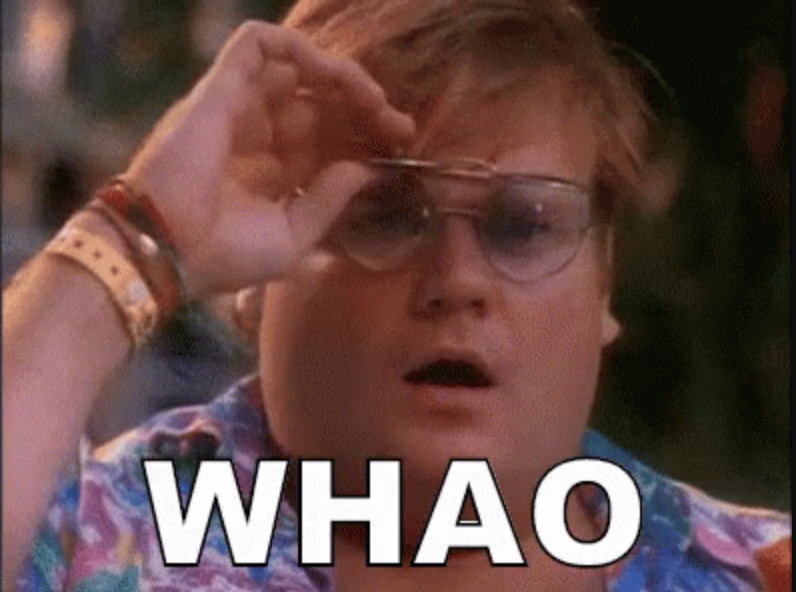

### It took us this number of parameters, but that's a pretty good approximation:

In [32]:
len(Optimal_Theta)

10000